[@dataymeric](https://github.com/dataymeric) <span style="float:right">21213744</span>

# TME - Régression & optimisation par descente de gradient

Ce TME a deux objectifs :

- acquérir les connaissances de base pour faire face au problème de la régression, c'est-à-dire de l'estimation d'un score réel correpondant à une situation,
- travailler sur les techniques d'optimisation par descente de gradient.


In [ ]:
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques :

- $N$ : nombre de points à générer.
- $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() (au choix).
  - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs.
- $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
  - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus.

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera - arbitrairement - 1000 points.

In [ ]:
def gen_data_lin(a, b, sig, N=500, Ntest=1000):
    # x ∈ [0,1]
    X_train = np.sort(np.random.rand(N))  # np.sort(np.random.rand(N)) sort optionnel, mais ça aide pour les plots
    X_test = np.linspace(0, 1, Ntest)
    # eps ~ N(0,sig²)
    eps_train = np.random.randn(N) * sig
    eps_test = np.random.randn(Ntest) * sig
    # y = ax + b + eps
    y_train = a * X_train + b + eps_train
    y_test = a * X_test + b + eps_test
    return X_train, y_train, X_test, y_test

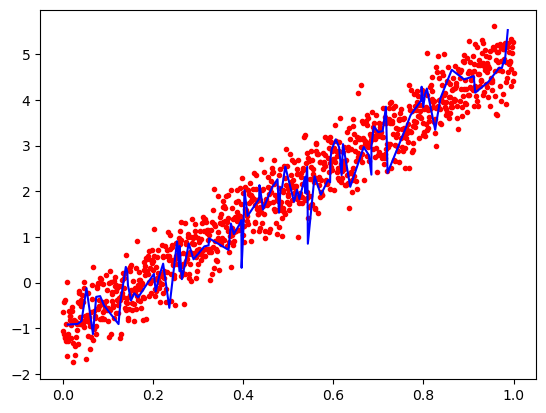

In [ ]:
# génération de données jouets :
a = 6.0
b = -1.0
N = 100
sig = 0.4  # écart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)


plt.figure()
plt.plot(X_test, y_test, "r.")
plt.plot(X_train, y_train, "b")
plt.show()

Vous devez obtenir quelque chose de la forme :
![données jouet](fig/gen_data.png)

## Validation des formules analytiques

Nous avons vu deux types de résolutions analytique : à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes

- $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
- $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$

Estimer les paramètres, calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test, puis tracer la droite de régression.

On rappelle que la matrice de covariance pour un couple de variables $(X,Y)$ se réprésente de la manière suivante :

$$
\begin{pmatrix}
\sigma_x^2 & \mbox{cov}(X,Y) \\
\mbox{cov}(Y,X) & \sigma_y^2
\end{pmatrix}
$$


In [ ]:
def modele_lin_analytique(X_train, y_train):
    cov = np.cov(X_train, y_train)
    ahat = cov[0][1] / cov[0][0]
    bhat = y_train.mean() - ahat * X_train.mean()
    return ahat, bhat


ahat, bhat = modele_lin_analytique(X_train, y_train)
display(Markdown(f"$\hat{{a}}={round(ahat,2)}$, $\hat{{b}}={round(bhat,2)}$"))

$\hat{a}=6.12$, $\hat{b}=-1.11$

In [ ]:
def erreur_mc(y, yhat):
    return ((y - yhat) ** 2).mean()


yhat_train = ahat * X_train + bhat
yhat_test = ahat * X_test + bhat

print("Erreur moyenne au sens des moindres carrés (train) :", erreur_mc(yhat_train, y_train))
print("Erreur moyenne au sens des moindres carrés (test)  :", erreur_mc(yhat_test, y_test))

Erreur moyenne au sens des moindres carrés (train) : 0.14463583543558323
Erreur moyenne au sens des moindres carrés (test)  : 0.17721667887519907


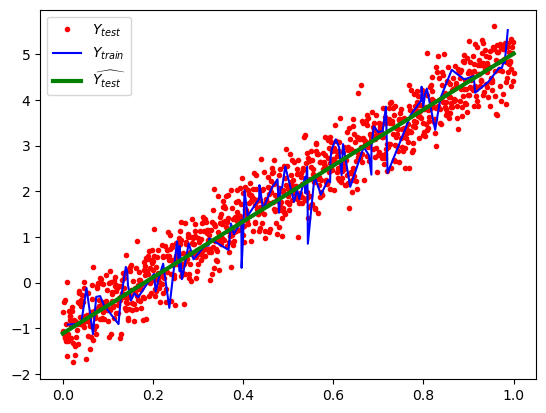

In [ ]:
plt.figure()
plt.plot(X_test, y_test, "r.", label="$Y_{test}$")
plt.plot(X_train, y_train, "b", label="$Y_{train}$")
plt.plot(X_test, yhat_test, "g", lw=3, label="$\widehat{Y_{test}}$")
plt.legend()
plt.show()

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $X_e$ :
$$X_e = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donné ci-dessous.

Il faut ensuite poser et résoudre un système d'équations linéaires de la forme :
$$ A w = B $$
**Rappel des formules vues en cours/TD :**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de résolution : `np.linalg.solve(A,B)`.

Vous devez obtenir la même solution que précédemment.

In [ ]:
def make_mat_lin_biais(X):  # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N, 1), np.ones((N, 1))))


def solve_cout(Xe, y):
    A = Xe.T @ Xe
    B = Xe.T @ y
    return np.linalg.solve(A, B)

In [ ]:
Xe = make_mat_lin_biais(X_train)
w = solve_cout(Xe, y_train)


display(Markdown(f"$\hat{{a}}={round(ahat,2)}$, $\hat{{b}}={round(bhat,2)}$"))
display(Markdown(f"$w={np.around(w,2)}$"))

$\hat{a}=6.12$, $\hat{b}=-1.11$

$w=[ 6.12 -1.11]$

Soit les données polynomiales générées avec la fonction ci-dessous :

- proposer une solution d'enrichissement (vue en cours et TD) ;
- résoudre analytiquement le problème des moindres carrés ;
- calculer l'erreur au sens des moindes carrés en apprentissage ET en test ;
- tracer les données et la solution.

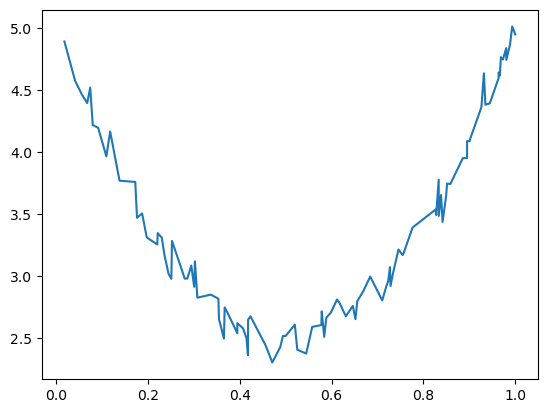

In [ ]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    """
    Tire N points X aléatoirement entre 0 et 1 et génère y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    """
    X_train = np.sort(np.random.rand(N))
    X_test = np.sort(np.random.rand(Ntest))
    y_train = a * X_train**2 + b * X_train + c + np.random.randn(N) * sig
    y_test = a * X_test**2 + b * X_test + c + np.random.randn(Ntest) * sig
    return X_train, y_train, X_test, y_test


Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(Xp_train, yp_train)
plt.show()

$$
X_e =
\begin{bmatrix}
X_0^2 & X_0 & 1\\
\vdots & \vdots & \vdots\\
X_N^2 & X_N & 1
\end{bmatrix}
$$

$$y = ax^2+bx+c+\epsilon$$

Le calcul de $w$ ne change pas : $Aw=B$.

In [ ]:
def make_mat_poly_biais(X):  # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N, 1) ** 2, X.reshape(N, 1), np.ones((N, 1))))


def pred(Xe, w):
    return [np.sum(x * w) for x in Xe]

Erreur moyenne au sens des moindres carrés (train) : 0.00984332766588623
Erreur moyenne au sens des moindres carrés (test)  : 0.01235681877445909


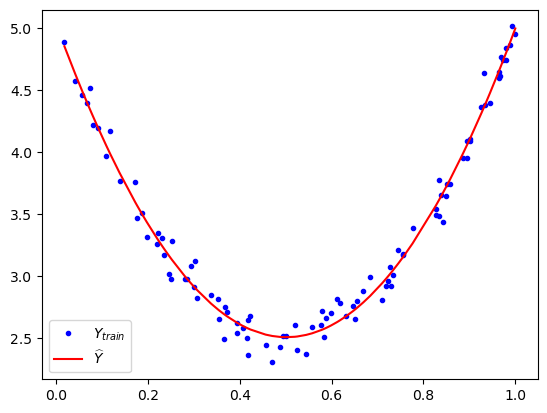

In [ ]:
Xe = make_mat_poly_biais(Xp_train)
Xe_t = make_mat_poly_biais(Xp_test)
w = solve_cout(Xe, yp_train)

yhat = pred(Xe, w)
yhat_t = pred(Xe_t, w)

print("Erreur moyenne au sens des moindres carrés (train) :", erreur_mc(yhat, yp_train))
print("Erreur moyenne au sens des moindres carrés (test)  :", erreur_mc(yhat_t, yp_test))

plt.figure()
plt.plot(Xp_train, yp_train, "b.", label="$Y_{train}$")
plt.plot(Xp_train, yhat, "r", label="$\widehat{Y}$")
plt.legend()
plt.show()

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût :
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de coût à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût :

$$ w^\star = \arg\min_w C(w)$$

**Rappel :** l'algorithme de la descente de gradient est le suivant :

- $w_0 \leftarrow init$ par exemple : 0
- Boucle
  - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Le gradient peut se calculer par la formule suivante, $E$ étant l'erreur cumulée :

$$\nabla_w E = 2X^T(Xw-Y)$$

Compléter le squelette d'implémentation fourni ci-dessous :

In [ ]:
# pour travailler en matrice: (re)construction de la matrice contenant les X et un biais
Xe = make_mat_lin_biais(X_train)  # dataset linéaire, transformation lineaire des données
wstar = solve_cout(Xe, y_train)  # pour se rappeler du w optimal


def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1])  # init à 0
    allw = [w]
    for i in range(nIterations):
        # calcul du gradient vu en TD
        gradient = 2 * X.T @ (X @ w - y)
        w = w - eps * gradient
        allw.append(w)  # stockage de toutes les valeurs intermédiaires pour analyse
    allw = np.array(allw)
    return w, allw  # la dernière valeur (meilleure) + tout l'historique pour le plot


w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=200)

On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


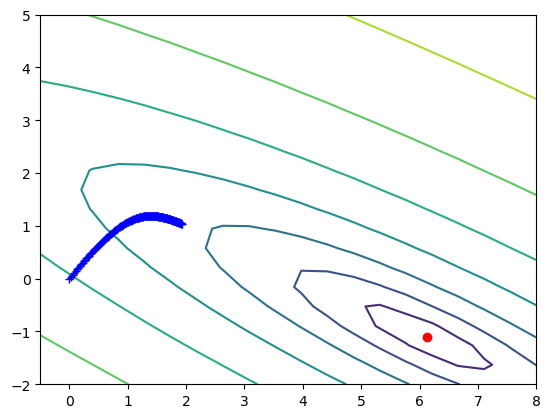

In [ ]:
# tracer de l'espace des couts
def plot_parametres(allw, X, y, opti=[], ngrid=20, extract_bornes=False):
    """
    Trace un historique de coefficients.
    ATTENTION : ça ne marche qu'en 2D (évidemment).
    Chaque w doit contenir 2 valeurs.

    Il faut fournir les données (X,y) pour calculer le cout associé à un jeu de paramètres w.
    ATTENTION : X = forme matricielle des données.
    """
    w_min = [-0.5, -2]  # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes:  # bornes générales
        w_min = np.min(allw, 0)  # trouver les bornes
        w_max = np.max(allw, 0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1, w2 = np.meshgrid(w1range, w2range)
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i, w2j]) - y) ** 2).sum()) for w1i in w1range] for w2j in w2range])
    # plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1], c="r")
    plt.plot(allw[:, 0], allw[:, 1], "b+-", lw=2)


plot_parametres(allw, Xe, y_train, opti=wstar)
# plt.savefig('fig/grad_descente.png')

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants :

- Divergence du gradient ;
- Convergence incomplète (trop lente ou pas assez d'itération) ;
- Convergence idéale : pas de gradient suffisamment grand et nombre d'itérations bien choisi.

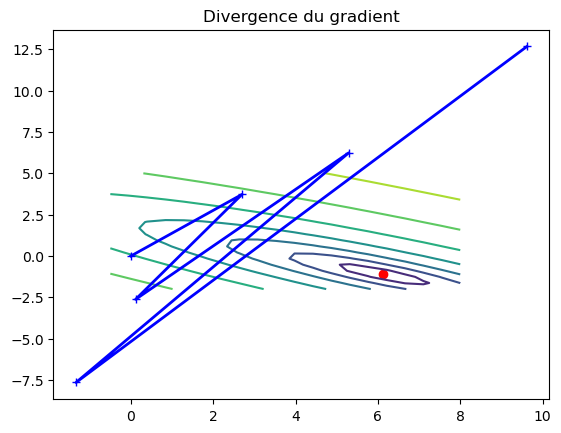

In [ ]:
w, allw = descente_grad_mc(Xe, y_train, eps=1e-2, nIterations=5)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title("Divergence du gradient")
plt.show()

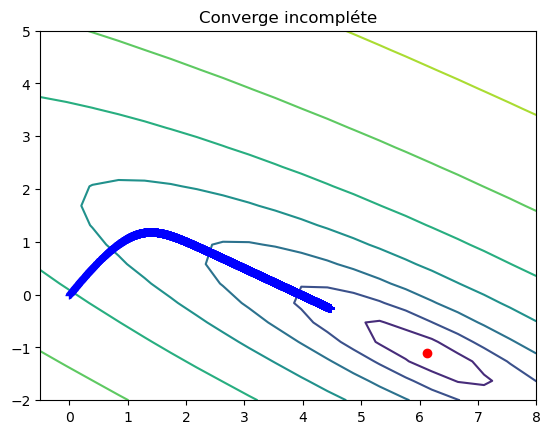

In [ ]:
w, allw = descente_grad_mc(Xe, y_train, eps=1e-5, nIterations=10000)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title("Converge incompléte")
plt.show()

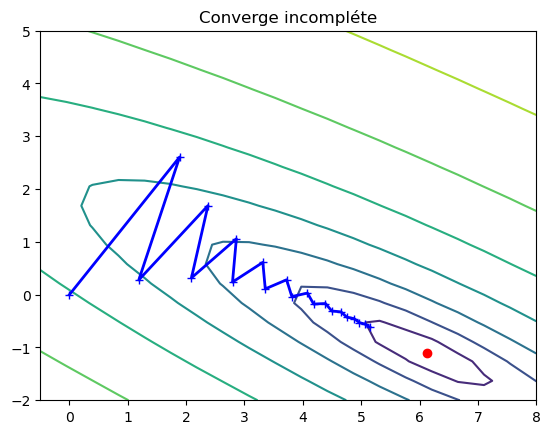

In [ ]:
w, allw = descente_grad_mc(Xe, y_train, eps=0.007, nIterations=20)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title("Converge incompléte")
plt.show()

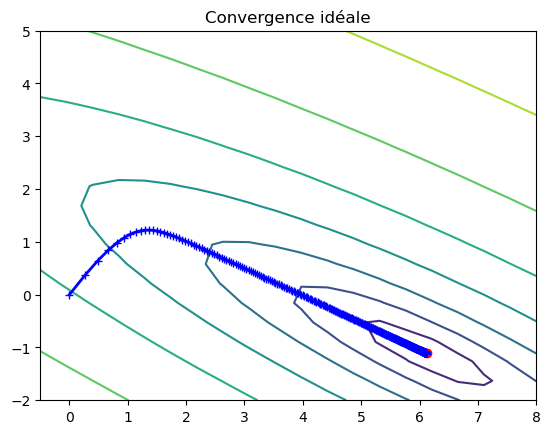

In [ ]:
w, allw = descente_grad_mc(Xe, y_train, eps=1e-3, nIterations=500)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title(f"Convergence idéale")
plt.show()

# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel : la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le TME** mais vous voulez plus d'informations :
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [ ]:
import pandas as pd

# Chargement des données
data = pd.read_csv("data/auto-mpg.data", delimiter="\s+", header=None)  # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => NaN pour travailler sur des nombres
data[data.columns[3]] = data[data.columns[3]].replace("?", None)
data[data.columns[3]] = data[data.columns[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data[data.columns[3]] = data[data.columns[3]].fillna(data[data.columns[3]].mean())

print(data.head())  # visualiser ce qu'il y a dans les données

X = np.array(data.values[:, 1:-2], dtype=np.float64)  # cylinders, ..., model years
y = np.array(data.values[:, 0], dtype=np.float64)  # mpg

      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [ ]:
np.random.seed(1)

# Séparation app/test
def separation_train_test(X, y, pc_train=0.75):
    # 1.1) générer tous les index entre 0 et N-1
    index = np.arange(X.shape[0])
    # 1.2) mélanger la liste
    np.random.shuffle(index)
    # 2.1) nb de points pour le train
    napp = int(len(y) * pc_train)
    # 3) Séparation
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test = X[index[napp:]], y[index[napp:]]
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [ ]:
# Résolution analytique
def make_mat_poly(X):
    return np.hstack((X, np.ones((X.shape[0], 1))))


Xe = make_mat_poly(X_train)
Xe_t = make_mat_poly(X_test)
w = solve_cout(Xe, y_train)

yhat = pred(Xe, w)
yhat_t = pred(Xe_t, w)
print("Erreur moyenne au sens des moindres carrés (train) :", erreur_mc(yhat, y_train))
print("Erreur moyenne au sens des moindres carrés (test)  :", erreur_mc(yhat_t, y_test))

Erreur moyenne au sens des moindres carrés (train) : 11.840817600718859
Erreur moyenne au sens des moindres carrés (test)  : 11.775783232233865


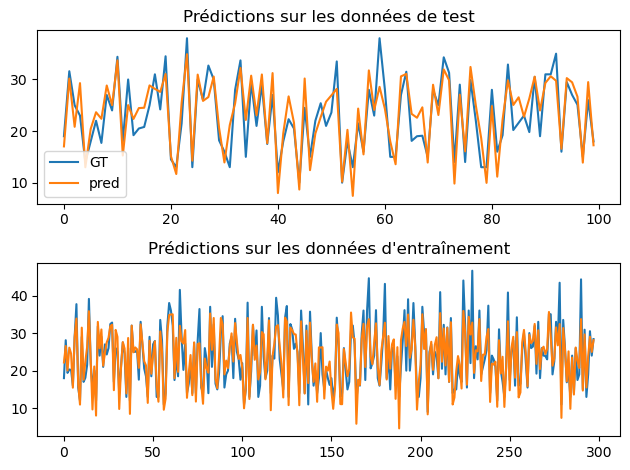

In [ ]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title("Prédictions sur les données de test")
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title("Prédictions sur les données d'entraînement")
    plt.tight_layout()
    plt.show()


plot_y(y_train, y_test, yhat, yhat_t)

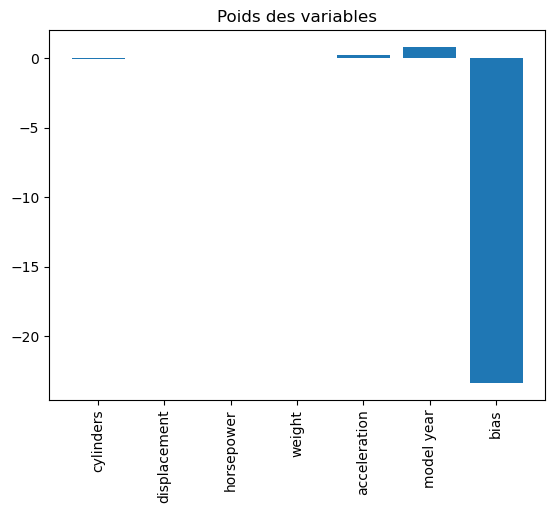

Poids des variables :  [-6.54508732e-02  4.59347970e-03  1.67232529e-02 -7.34471693e-03
  2.62150649e-01  8.21965763e-01 -2.33697783e+01]


In [ ]:
# interprétation des poids
names = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "bias"]
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.title("Poids des variables")
plt.xticks(range(len(names)), names, rotation="vertical")
plt.show()

print("Poids des variables : ", w)

La variable biais est la variable la plus importante du modèle... sans normalisation, toutes les autres variables ont un poids faible ou quasi nul.

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base :

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Leftrightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**Attention :** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.


In [ ]:
def normalisation(X_train, X_test):
    """
    Fonction de normalisation des données pour rendre les colonnes comparables.
    Chaque variable sera assimilée à une loi normale qu'il faut centrer + réduire.
    ATTENTION: il faut calculer les moyennes et écarts-types sur les données d'apprentissage seulement.
    """
    # A compléter
    # 1) calcul des moyennes et écarts types pour chaque colonne
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    # 2) normalisation des colonnes
    Xn_train = (X_train - mu) / std
    Xn_test = (X_test - mu) / std

    # 3) Ajout d'un biais
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0], 1))))
    Xn_test = np.hstack((Xn_test, np.ones((X_test.shape[0], 1))))

    return Xn_train, Xn_test


Xn_train, Xn_test = normalisation(X_train, X_test)

Erreur moyenne au sens des moindres carrés (train) : 11.840817600718855
Erreur moyenne au sens des moindres carrés (test)  : 11.775783232233675
Poids des variables :  [-0.11092442  0.48737239  0.64924702 -6.38493119  0.72532889  3.01953827
 23.73489933]


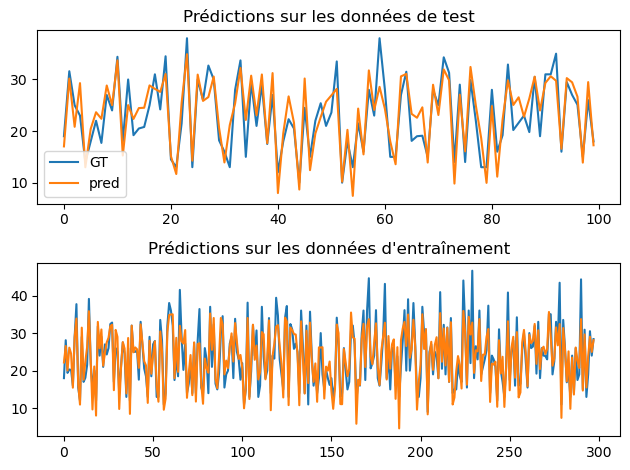

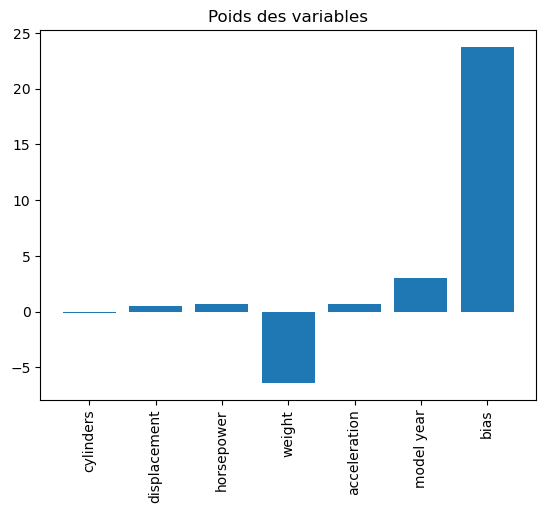

In [ ]:
w = solve_cout(Xn_train, y_train)

yhat = pred(Xn_train, w)
yhat_t = pred(Xn_test, w)

print("Erreur moyenne au sens des moindres carrés (train) :", erreur_mc(yhat, y_train))
print("Erreur moyenne au sens des moindres carrés (test)  :", erreur_mc(yhat_t, y_test))
print("Poids des variables : ", w)

# prédictions
plot_y(y_train, y_test, yhat, yhat_t)

# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.title("Poids des variables")
plt.xticks(range(len(names)), names, rotation="vertical")
plt.show()

Après normalisation, la variable biais est (toujours) la variable ayant le plus grand impact sur le modèle, suivi de la variable `weight`, puis de la variable `model year`. Toutefois, leurs impacts sont moindres comparés au biais...

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables servent moins ?


Erreur moyenne au sens des moindres carrés (train) : 11.606487662037386
Erreur moyenne au sens des moindres carrés (test)  : 12.10223035578953
Poids des variables :  [-5.50846593  2.83280846 23.38456376]


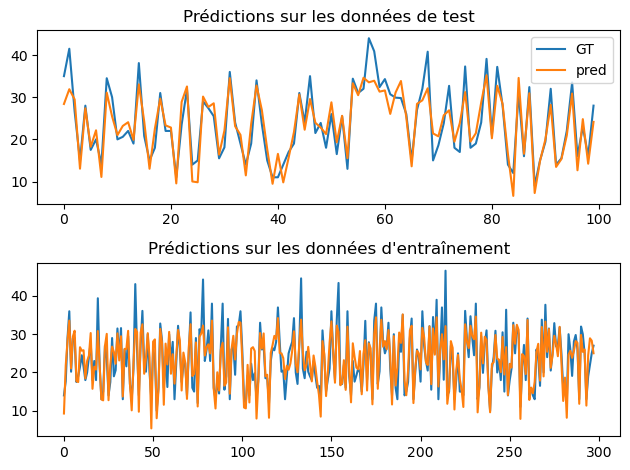

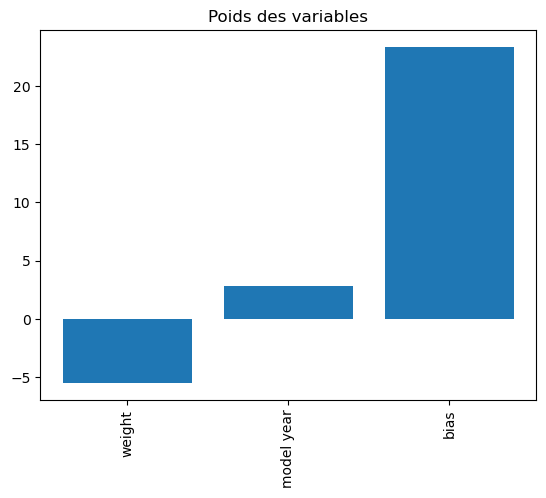

In [ ]:
names = ["weight", "model year", "bias"]
X = np.array(data[[4, 6]].values, dtype=np.float64)
X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)
Xn_train, Xn_test = normalisation(X_train, X_test)
w = solve_cout(Xn_train, y_train)

yhat = pred(Xn_train, w)
yhat_t = pred(Xn_test, w)

print("Erreur moyenne au sens des moindres carrés (train) :", erreur_mc(yhat, y_train))
print("Erreur moyenne au sens des moindres carrés (test)  :", erreur_mc(yhat_t, y_test))
print("Poids des variables : ", w)

# prédictions
plot_y(y_train, y_test, yhat, yhat_t)

# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.title("Poids des variables")
plt.xticks(range(len(names)), names, rotation="vertical")
plt.show()

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve :

1. `mpg`: continuous
2. `cylinders`: multi-valued discrete
3. `displacement`: continuous
4. `horsepower`: continuous
5. `weight`: continuous
6. `acceleration`: continuous
7. `model year`: multi-valued discrete
8. `origin`: multi-valued discrete

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante :

```python
origine = data.values[:,-2]
```

Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding :

$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions. Enfin, il n'y a que 13 années... compliqué à découper en 10 catégories (surtout si l'on souhaite être cohérent dans les intervalles)...

In [ ]:
names = np.hstack(
    (
        ["cylinders", "displacement", "horsepower", "weight", "acceleration"],
        pd.get_dummies(data[7], prefix="origin").columns,
        pd.get_dummies(data[6], prefix="year").columns,
        "bias",
    )
)

# encodage one-hot des variables `origine` et `model year`
origine = np.array(pd.get_dummies(data[7], prefix="origin").values)
year = np.array(pd.get_dummies(data[6], prefix="year").values)

# chargement des données
X = np.hstack((np.array(data.values[:, 1:6], dtype=np.float64), origine, year))
y = np.array(data.values[:, 0], dtype=np.float64)  # mpg

# séparation des données
X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

Erreur moyenne au sens des moindres carrés (train) : 9.332901935212615
Erreur moyenne au sens des moindres carrés (test)  : 8.503967633557062


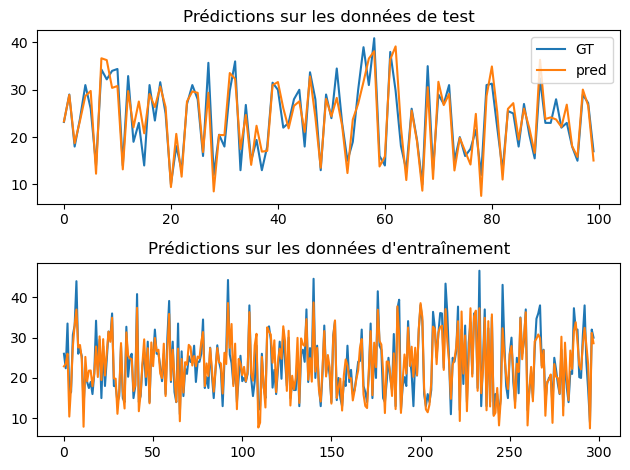

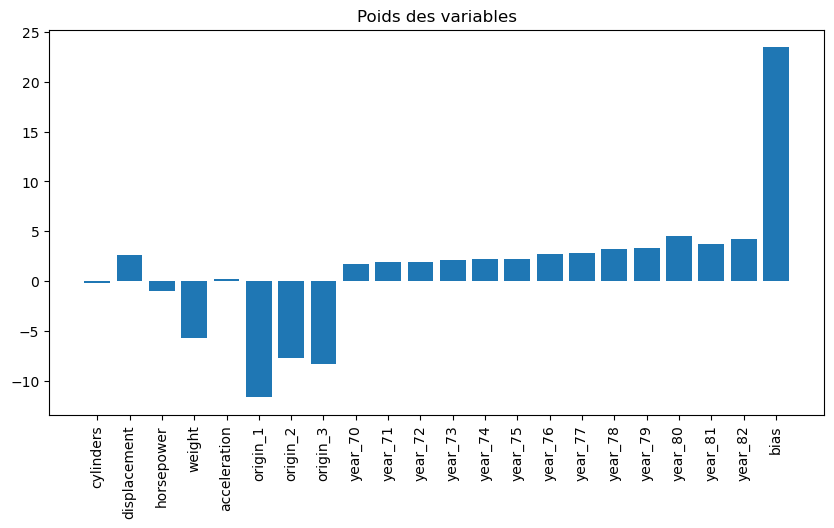

In [ ]:
Xn_train, Xn_test = normalisation(X_train, X_test)
w = solve_cout(Xn_train, y_train)

yhat = pred(Xn_train, w)
yhat_t = pred(Xn_test, w)

print("Erreur moyenne au sens des moindres carrés (train) :", erreur_mc(yhat, y_train))
print("Erreur moyenne au sens des moindres carrés (test)  :", erreur_mc(yhat_t, y_test))

# prédictions
plot_y(y_train, y_test, yhat, yhat_t)

# interprétation des poids
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(w)), w)
plt.title("Poids des variables")
plt.xticks(range(len(names)), names, rotation="vertical")
plt.show()

Les facteurs importants pour le calcul de la consommation semblent être l'origine de la voiture, le poids, les modèles des années 1980 à 1982, sans oublier le biais.

## Impact de la normalisation sur le gradient

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur...). Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale ?

In [ ]:
# génération de données jouets :
a = 6.0
b = -1.0
N = 100
sig = 0.4  # écart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)

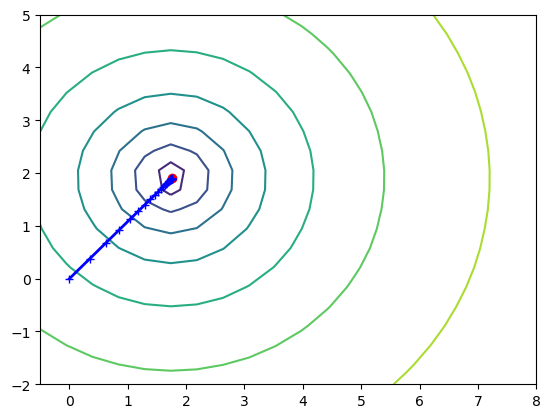

In [ ]:
# impact de la normalisation sur le gradient
mu = X_train.mean()
std = X_train.std()

# normalisation
Xn_train = (X_train - mu) / std

Xe = make_mat_lin_biais(Xn_train)
wstar = solve_cout(Xe, y_train)

w, allw = descente_grad_mc(Xe, y_train, eps=1e-3, nIterations=30)
plot_parametres(allw, Xe, y_train, opti=wstar)

En normalisant les données, notre descente de gradient est beaucoup plus stable, beaucoup plus rapide et beaucoup plus direct... (au sens littéral du terme : la descente de gradient va "tout droit" !)

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois :

- $w_0 \leftarrow init$ par exemple : 0
- boucle
  - tirage d'une donnée $i$ : $(x_i,y_i)$
  - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$

Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

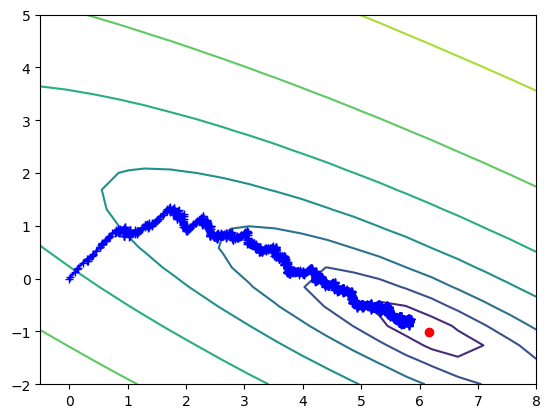

In [ ]:
np.random.seed(1000)

Xe = make_mat_lin_biais(X_train)  # dataset linéaire, transformation lineaire des données
wstar = solve_cout(Xe, y_train)  # pour se rappeler du w optimal


def descente_grad_sto(X, y, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1])  # init à 0
    allw = [w]
    for i in range(nIterations):
        # tirage d'une donnée i
        i = np.random.randint(X.shape[0])
        # calcul du gradient
        gradient = 2 * np.dot(X[i].T, (np.dot(X[i], w) - y[i]))
        w = w - eps * gradient
        # stockage de toutes les valeurs intermédiaires pour analyse
        allw.append(w)
    allw = np.array(allw)
    return w, allw  # la dernière valeur (meilleure) + tout l'historique pour le plot


w, allw = descente_grad_sto(Xe, y_train, eps=1e-2, nIterations=2000)
plot_parametres(allw, Xe, y_train, opti=wstar)

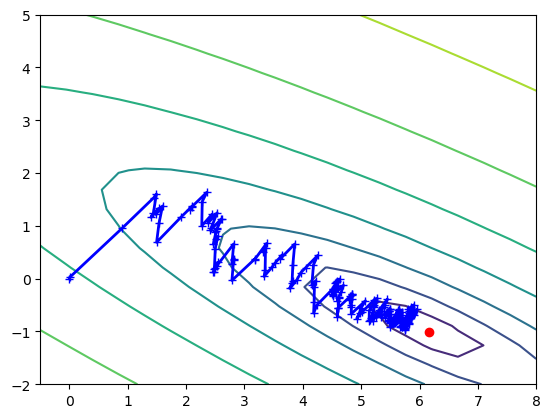

In [ ]:
w, allw = descente_grad_sto(Xe, y_train, eps=1e-1, nIterations=250)
plot_parametres(allw, Xe, y_train, opti=wstar)

## Amélioration du gradient

Le [blog de S. Ruder](https://ruder.io/optimizing-gradient-descent/) explique particulièrement bien les améliorations possibles sur les descentes de gradient.

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.

_**D'après l'article**_ :

### La méthode du moment
Le *batch gradient* (`descente_grad_mc`) effectue des calculs redondants pour les grands ensembles de données, car elle recalcule les gradients pour des exemples similaires avant chaque mise à jour des paramètres. Le gradient stochastique (`descente_grad_sto`) élimine cette redondance en effectuant une seule mise à jour à la fois. En général, il est donc beaucoup plus rapide et peut également être utilisée pour l'apprentissage en ligne. Cependant, cette méthode effectue des mises à jour fréquentes avec une variance élevée qui entraîne une forte fluctuation de la fonction objectif. 

La méthode du moment permet d'accélérer le gradient stochastique dans la direction voulue et d'amortir ainsi les oscillations. Elle y parvient en ajoutant une fraction $\gamma$ du vecteur de vélocité $v$ défini par :

$$v_{t+1} = \gamma v_{t} + \epsilon \nabla_w C(w)$$
$$w_{t+1} = w_t - v_{t+1}$$

Le terme de moment $\gamma$ est généralement fixé à 0,9 ou à une valeur similaire. Le terme augmente pour les dimensions dont les gradients pointent dans les mêmes directions et réduit ainsi les mises à jour pour les dimensions dont les gradients changent de direction. Par conséquent, nous obtenons une convergence plus rapide et une oscillation réduite, comme nous pouvons l'observer.

In [ ]:
def descente_grad_sto_momentum(X, y, momentum=0.9, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1])  # init à 0
    allw = [w]
    v = w
    for i in range(nIterations):
        # tirage d'une donnée i
        i = np.random.randint(X.shape[0])
        # calcul du gradient
        gradient = 2 * np.dot(X[i].T, (np.dot(X[i], w) - y[i]))
        v = momentum * v + eps * gradient
        w = w - v
        # stockage de toutes les valeurs intermédiaires pour analyse
        allw.append(w)
    allw = np.array(allw)
    return w, allw  # la dernière valeur (meilleure) + tout l'historique pour le plot

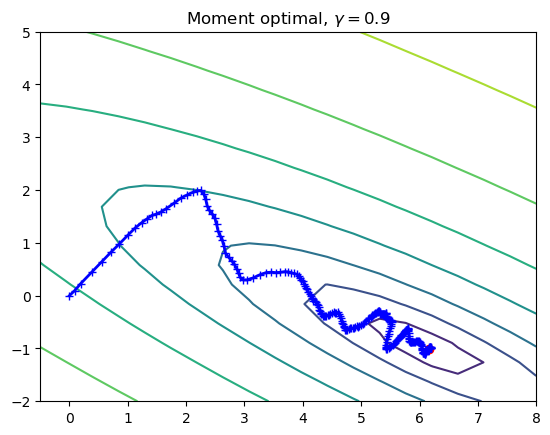

In [ ]:
w, allw = descente_grad_sto_momentum(Xe, y_train, eps=1e-2, nIterations=250)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title("Moment optimal, $\gamma=0.9$")
plt.show()

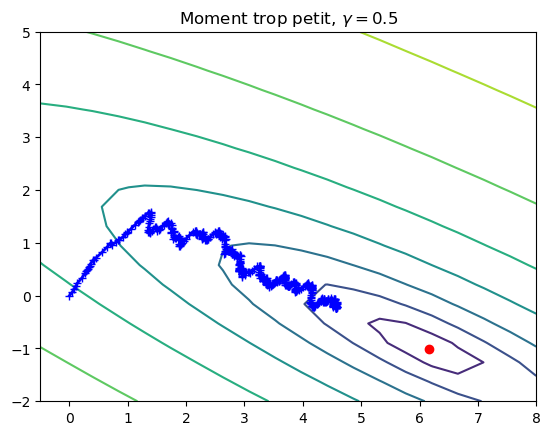

In [ ]:
w, allw = descente_grad_sto_momentum(Xe, y_train, momentum=0.5, eps=1e-2, nIterations=500)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title("Moment trop petit, $\gamma=0.5$")
plt.show()

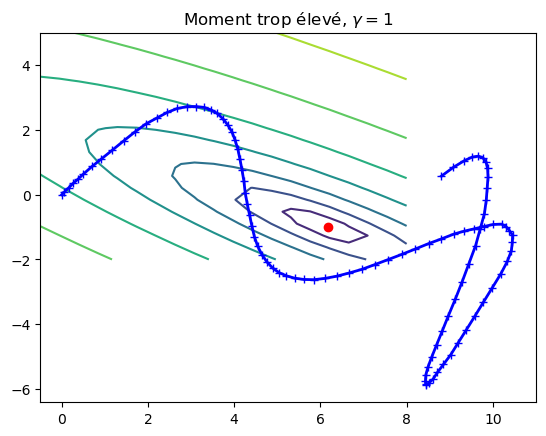

In [ ]:
w, allw = descente_grad_sto_momentum(Xe, y_train, momentum=1.0, eps=1e-2, nIterations=100)
plot_parametres(allw, Xe, y_train, opti=wstar)
plt.title("Moment trop élevé, $\gamma=1$")
plt.show()

Des stratégies supplémentaires pouvant améliorer les performances du gradien stochastique :
- mélanger les données :  mélanger les données d'apprentissage après chaque itération afin d'éviter de fournir les données d'apprentissage dans un ordre significatif à notre modèle ;
- normalisation ;
- *early stopping* : surveiller l'erreur sur les données de test pendant l'apprentissage et arrêter si l'erreur de validation ne s'améliore pas suffisamment (avec un peu de patience)  ;
- ajout d'un bruit : Neelakantan, A., Vilnis, L., Le, Q., Sutskever, I., Kaiser, L., Kurach, K., & Martens, J.. (2015). [Adding Gradient Noise Improves Learning for Very Deep Networks](https://arxiv.org/abs/1511.06807).